In [1]:
import torch
import torch.nn as nn

In [8]:
import tiktoken

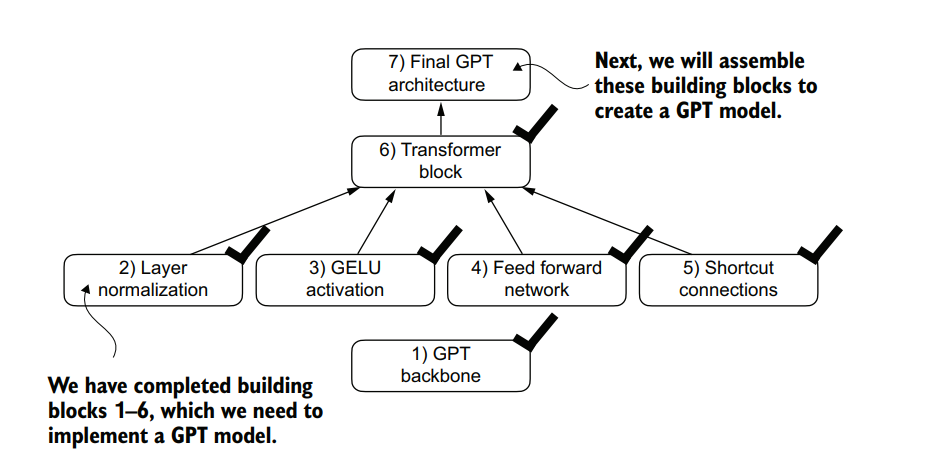

### The GPT model:

In the case of the 124-million-parameter GPT-2 model, transformer block is repeated 12 times, which we specify via the n_layers entry in the `GPT_CONFIG_124M` dictionary. This
transform block is repeated 48 times in the largest GPT-2 model with 1,542 million
parameters.

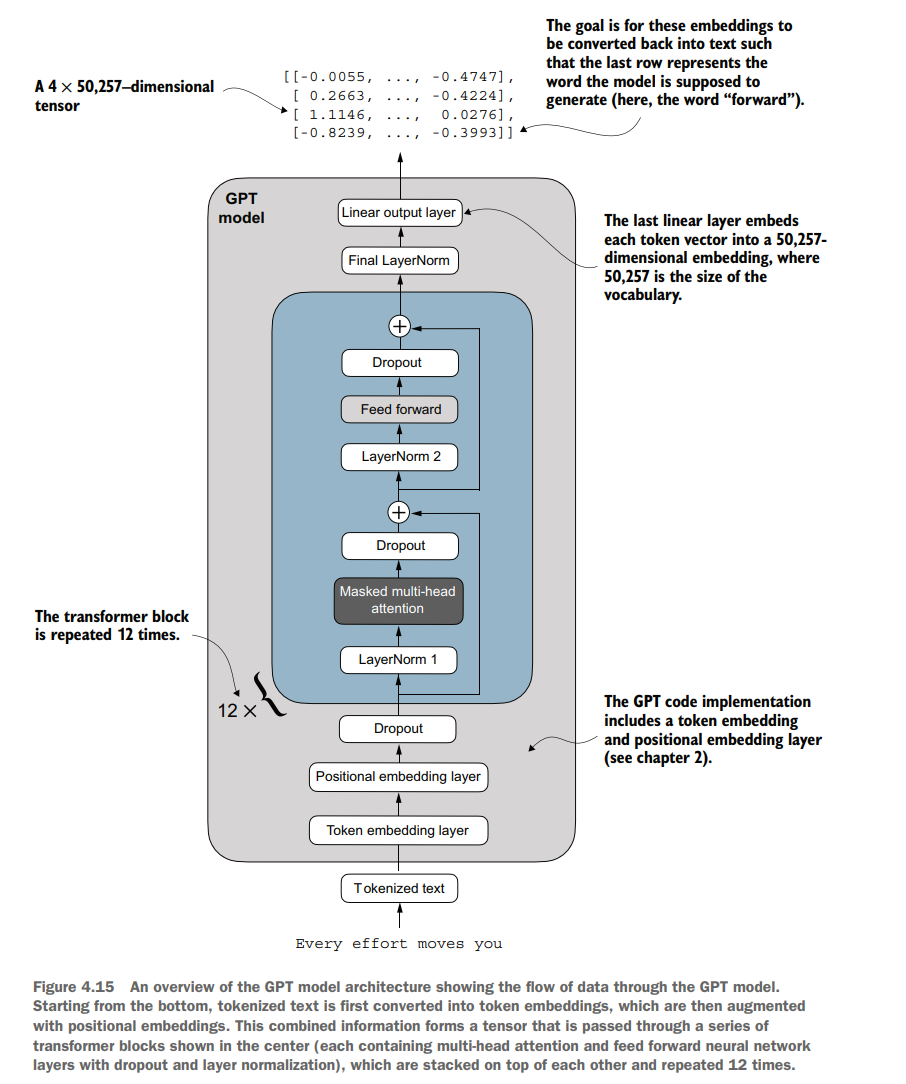

Let’s now replace the `DummyTransformerBlock` and `DummyLayerNorm` placeholders with the real   `TransformerBlock` and `LayerNorm` classes we coded previously in 1_dummy_gpt.ipynb to assemble a fully working version of the original 124-million-parameter version of GPT-2

In [4]:
from utils.transformer import TransformerBlock
from utils.layernorm import LayerNorm

In [ ]:
class GPTModel(nn.Module):
    
    def __init__(self, config):

        super().__init__()

        self.tok_emb = nn.Embedding(config["vocab_size"], config["emb_dim"])
        # for gpt - 2 small, vocab_size = 50257 and emb_dim = 768
        # This matrix is also called lookup table we pass in the token id and get the corresponding embedding
        # Also a trainable parameter

        self.pos_emb = nn.Embedding(config["context_length"], config["emb_dim"])

        self.drop_emb = nn.Dropout(config["drop_rate"])


        # This is a sequential container that contains n_layers transformer blocks
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(config) for _ in range(config["n_layers"])]
        )
        ''' The * unpacks the list so that nn.Sequential receives block1, block2, block3 as separate arguments, matching its expected input.'''
        # Placeholder for the LayerNorm
        self.final_norm = LayerNorm(config["emb_dim"])
        
        self.out_head = nn.Linear(config["emb_dim"], config["vocab_size"], bias=False)




    def forward(self, in_idx):
        # in_idx is the input token ids
        batch_size, seq_len = in_idx.shape
        
        # What we are doing here is looking up the token ids in token embedding matrix created in the constructor 
        # to get the 768 embedding vectors for each token id of the input sequence
        # So, if one batch has 4 tokens, for each batch we will get 4 embedding vectors of size 768
        tok_embeds = self.tok_emb(in_idx) 
        ''' For each token ID, nn.Embedding retrieves a vector of shape (emb_dim,), so tok_embeds has shape (batch_size, seq_len, emb_dim).'''


        # We are creating a position embedding matrix of size (seq_len, emb_dim)
        # What arange is doing is creating a tensor of size (seq_len) with values from 0 to seq_len - 1
        # And then we are passing this tensor to position embedding to get only that many position embeddings
        pos_embeds = self.pos_emb(torch.arange(seq_len, device = in_idx.device))
        '''
        pos_embeds is not the entire positional embedding matrix. It’s a tensor of shape (seq_len, emb_dim) containing only the embeddings for the positions [0, 1, ..., seq_len-1]. Only seq_len rows of the (context_length, emb_dim) matrix are used.
        '''
        # We are adding the token embeddings and position embeddings (both 768 dimensional vectors)
        # This is the final embedding matrix we will pass to the transformer
        x = tok_embeds + pos_embeds

        '''
        Here, pos_embeds (shape (seq_len, emb_dim)) is broadcasted to match tok_embeds (shape (batch_size, seq_len, emb_dim)).
        Broadcasting replicates pos_embeds across the batch_size dimension, effectively treating it as (batch_size, seq_len, emb_dim) for the addition.

        The result x has shape (batch_size, seq_len, emb_dim).
        '''

        # We are applying dropout to the embedding matrix which is a regularization technique
        x = self.drop_emb(x)

        x = self.trf_blocks(x)  # (batch_size, num_tokens, emb_dim)
        
        x = self.final_norm(x)  # (batch_size, num_tokens, emb_dim)

        logits = self.out_head(x)
        # This will output a tensor of shape (batch_size, num_tokens, vocab_size)
        return logits


In [9]:
GPT_CONFIG_124M = {
 "vocab_size": 50257, # Vocabulary size
 "context_length": 1024, # Context length
 "emb_dim": 768, # Embedding dimension
 "n_heads": 12, # Number of attention heads
 "n_layers": 12, # Number of layers
 "drop_rate": 0.1, # Dropout rate
 "qkv_bias": False # Query-Key-Value bias
}




In [10]:
tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [11]:
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.0072, -0.2137, -0.3467,  ..., -0.3240, -0.2338, -0.1070],
         [ 0.7063, -0.7429, -0.6645,  ..., -0.6530, -0.1393, -0.2166],
         [ 0.8226, -0.2982, -0.4547,  ...,  0.0913, -0.6949, -0.2091],
         [-0.3933,  0.3074, -0.1343,  ...,  1.0464,  0.4620, -0.5298]],

        [[ 0.1386, -0.4081, -0.1563,  ..., -0.0892, -0.0672, -0.0157],
         [ 0.2353, -0.1177, -0.1307,  ...,  1.0729, -0.3517,  0.3905],
         [ 0.7367,  0.3377, -0.4311,  ...,  0.8471,  0.2219, -0.2541],
         [ 0.0166, -0.0721,  0.3451,  ...,  1.1352, -0.4069,  0.0309]]],
       grad_fn=<UnsafeViewBackward0>)


Using the `numel()` method, short for “number of elements,” we can collect the total
number of parameters in the model’s parameter tensors:

In [12]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


#### But the GPT model we designed was supposed to have 124 million parameters!!

So where did the extra ~39 million come from?

Weight tying is a technique where two layers in the model share the same weights, instead of each having their own separate parameters.

In GPT-2, this happens between:

    The token embedding layer (input layer that turns token IDs into vectors)

    The output projection layer (the final layer that maps hidden states back to vocabulary logits)

Instead of learning two separate big matrices (one for input, one for output), GPT-2 uses the same matrix for both. 

In [13]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [14]:
total_params_gpt2 = (
 total_params - sum(p.numel()
 for p in model.out_head.parameters())
)
print(f"Number of trainable parameters "
 f"considering weight tying: {total_params_gpt2:,}"
)

Number of trainable parameters considering weight tying: 124,412,160


Let’s compute the memory requirements of the 163 million parameters in our
`GPTModel` object:

In [ ]:
total_size_bytes = total_params * 4 
# Assuming 4 bytes per parameter (float32)
total_size_mb = total_size_bytes / (1024 * 1024) 
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


### Summary of GPT model

#### Step 1: Token embedding

Convert the token ids into specified dimensional vector representation
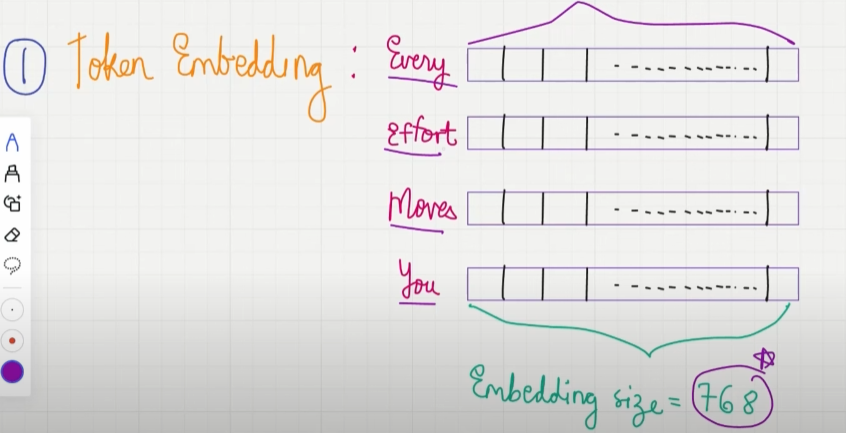

#### Step 2: Positional embedding

Embed the positional information of the tokens
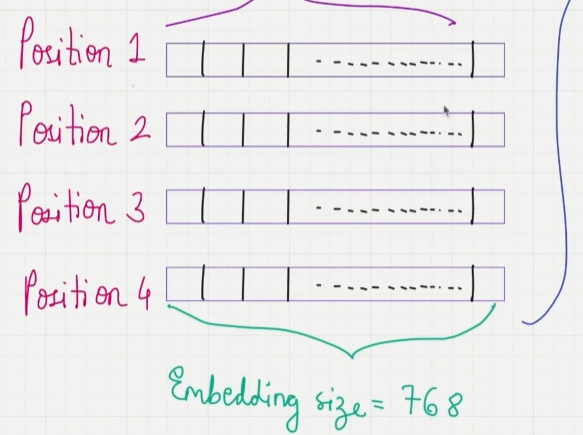

#### Step 3: Adding them

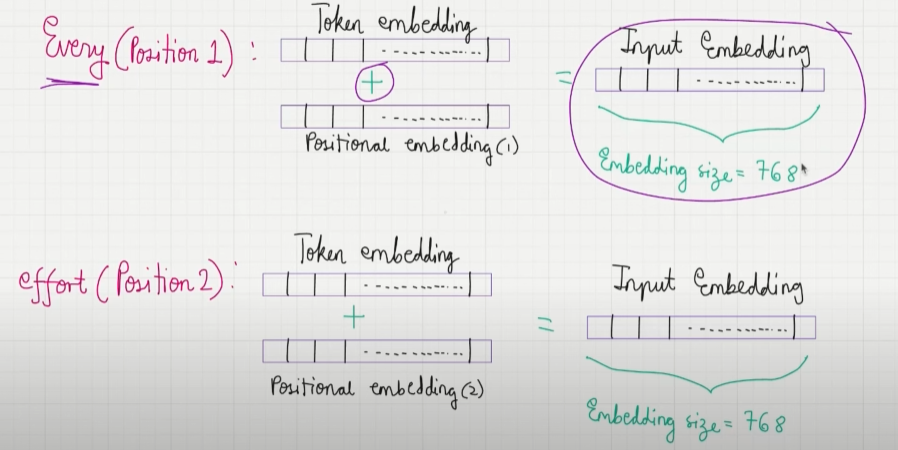

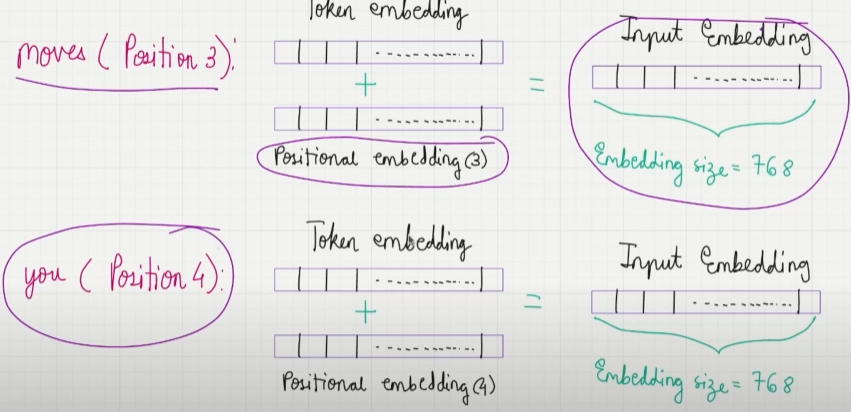

#### Step 4: Drop out

To prevent overfitting
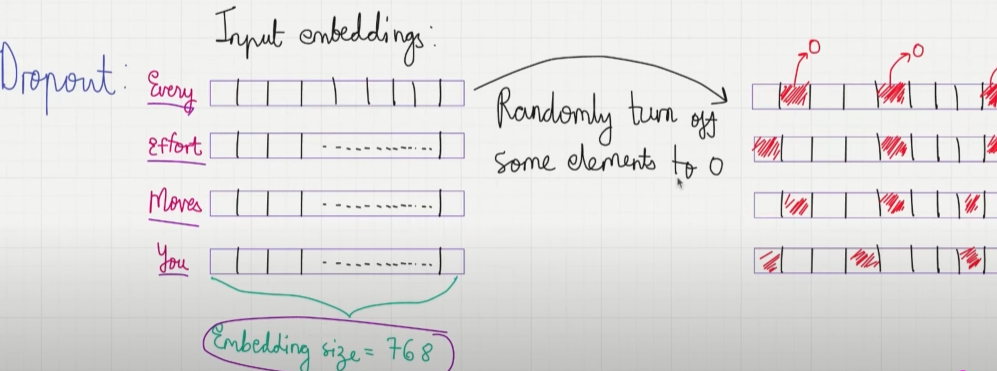

#### Step 5: Transformer block

##### Step 5.1: Layer normalization

For controlling gradient magnitudes and stabilizing training by making the embeddings have a mean of 0 and variance of 1
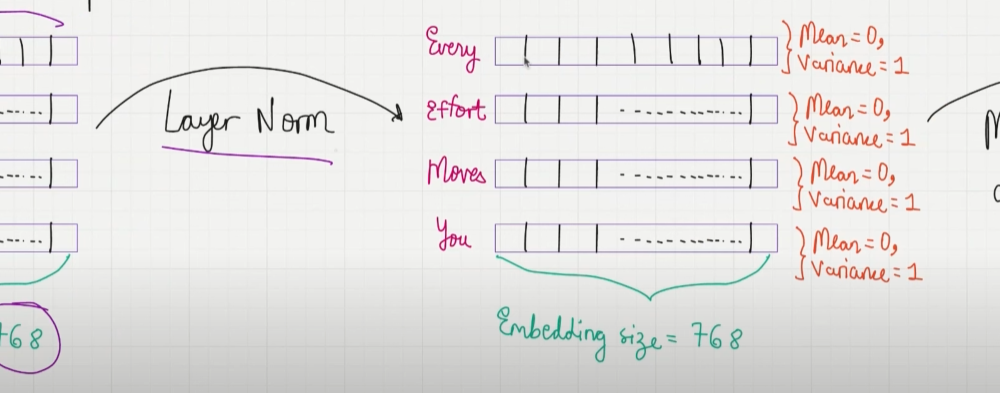

##### Step 5.2: Masked Multi-head attention

Add the attention information for each token relative to every other token
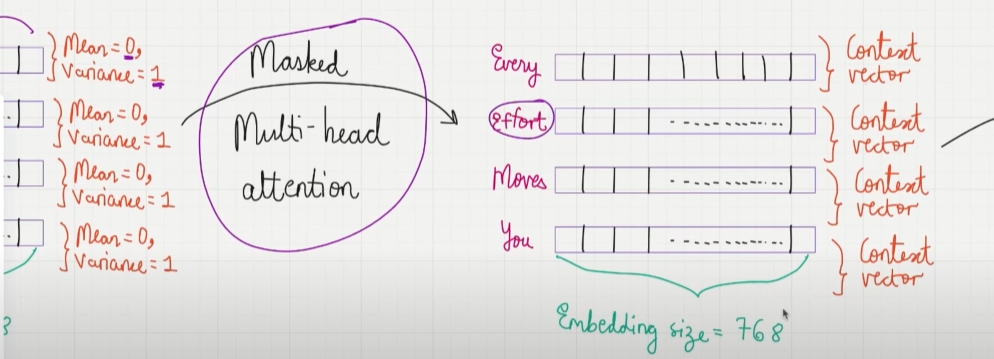

##### Step 5.3: Dropout (first dropout transformer)

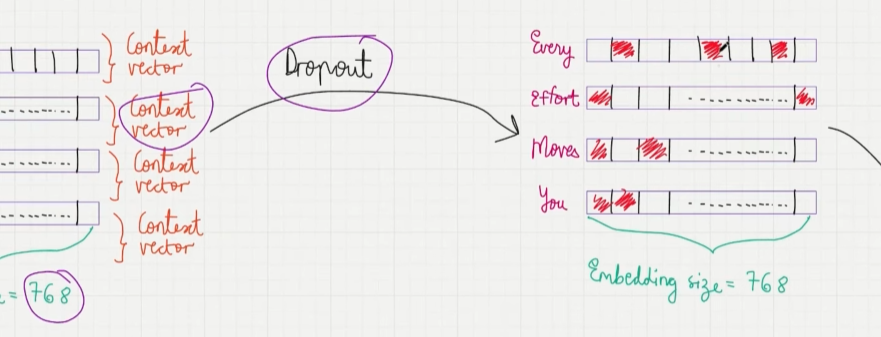

##### Step 5.4: Skip connection (Addind with input to transformer)

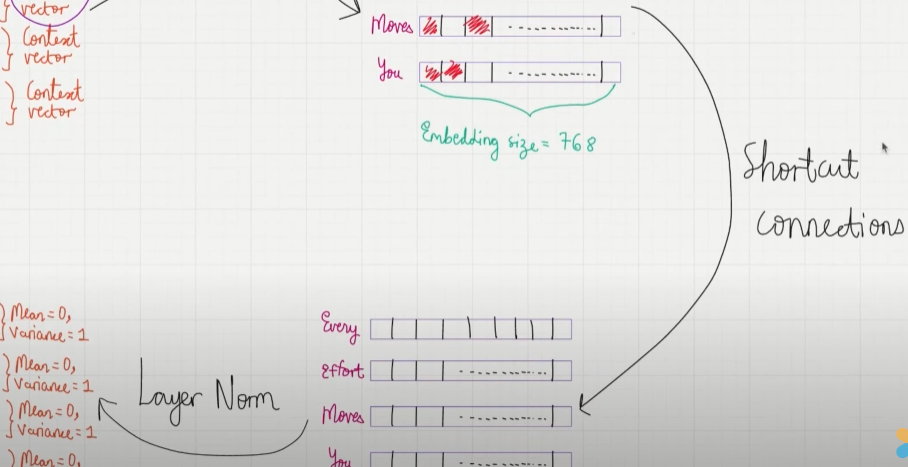

##### Step 5.5: Layer Norm once again

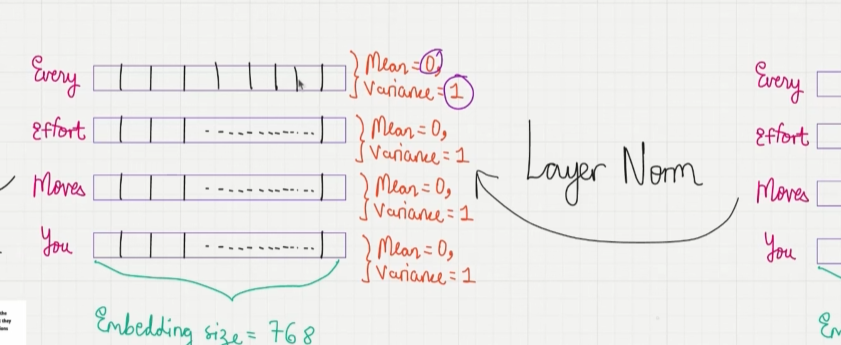

##### Step 5.6: Feed forward NN

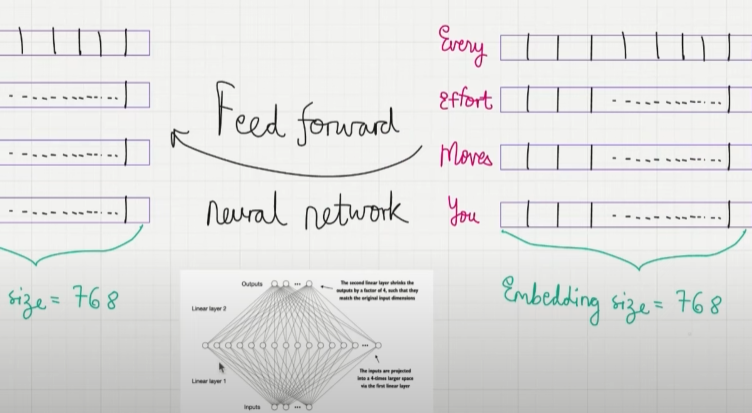

##### Step 5.7: Dropout (second dropout inside transformer)

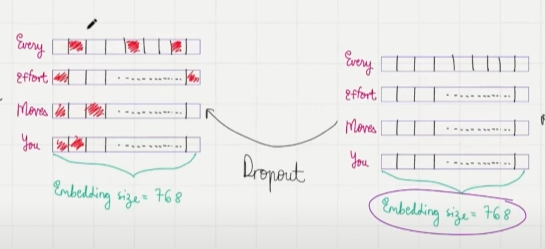

##### Step 5.8: Skip connection again and the output of Transformer block

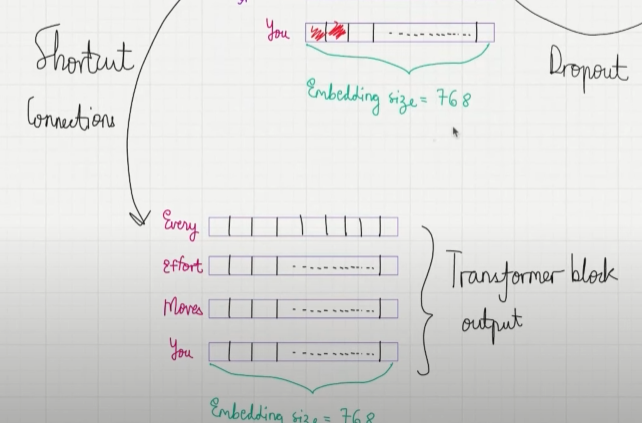

#### Step 6: Layer Normalization to the transformer output

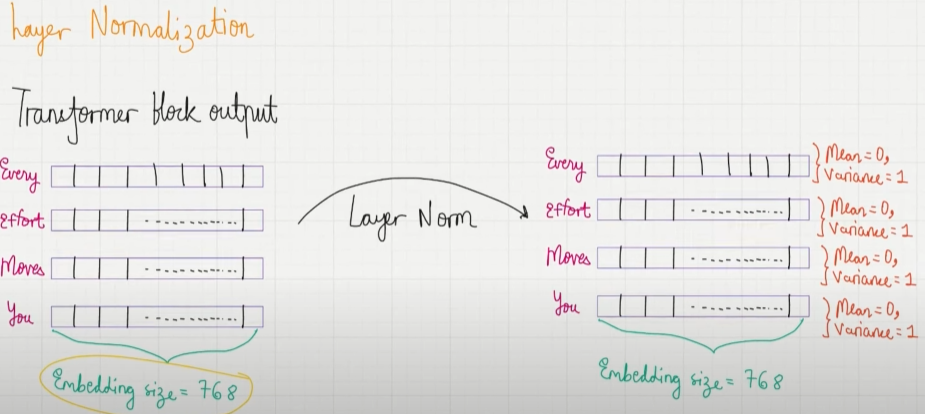

#### Step 7: Output head (To get the logits for all vocabularies)

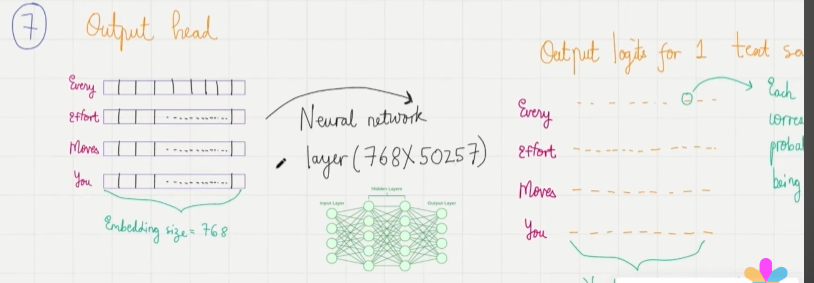
